In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

По этическим причинам(мне так PyCharm указал, так как там есть рассовая несправедливость), выбрал датасет по домам в Калифорнии:)

Загружаем датасет, в X добавляем признаки, в y целевое значение , также немного редактируем выборку, для снижение корреляции между признаками

In [6]:
cal_df = fetch_california_housing()
X = pd.DataFrame(data=cal_df.data, columns=cal_df.feature_names)
y = cal_df.target

In [7]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [8]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Ради приличия посмотрим на тепловую карту корреляции

<AxesSubplot:>

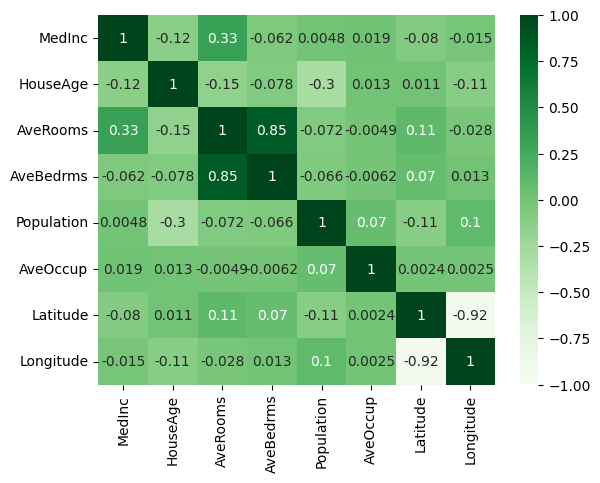

In [9]:
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap='Greens', annot=True)

У нас есть два признака, которые сильноскоррелированы(Количество спален от количества комнат в квартире). Попробуем округлить результат по данным из данных признаков и посмотрим на результат

In [10]:
X['AveRooms'] = X['AveRooms'].apply(np.ceil)
X['AveBedrms'] = X['AveBedrms'].apply(np.ceil)

<AxesSubplot:>

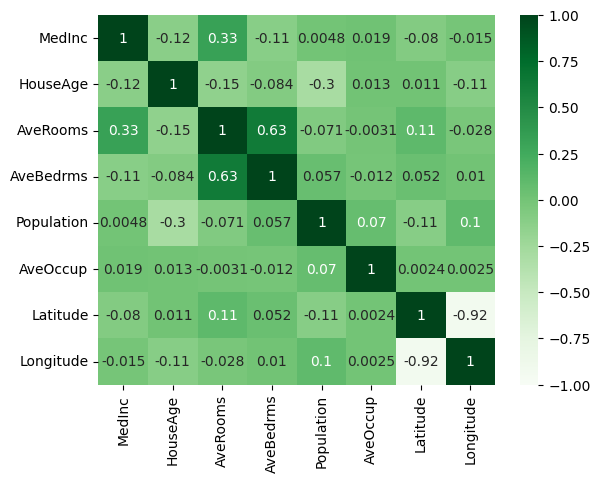

In [11]:
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap='Greens', annot=True)

Стало получше. Для линейных моделей лучше либо снижать линейную корреляцию, либо не брать данные признаки. Для дерева решений линейная корреляция особой роли не играет

Разбиваем нашу выборку на обучение и тест

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

Так как я выбрал дерево решений, необходимо подобрать параметры, для получения оптимальных метрик. Будем искать три основных параметра Max_depth - максимальная глубина нашего дерева, min_samples_leaf - минимальное количество объектов в листе нашего дерева и max_leaf_nodes - максимальное количество листьев

In [16]:
treeReg = DecisionTreeRegressor()

param = {'max_depth': range(1, 20, 5),
             'min_samples_leaf': range(1, 8),
             'max_leaf_nodes': range(2, 20, 2)}
gd = GridSearchCV(treeReg, param)
gd.fit(X_train, y_train)
gd.best_params_

{'max_depth': 6, 'max_leaf_nodes': 18, 'min_samples_leaf': 4}

Далее обучаем нашу модель и смотрим метрики

In [13]:
model_tree = DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, max_leaf_nodes=18)
model_tree.fit(X_train, y_train)

pred_tr = model_tree.predict(X_train)
train = pd.DataFrame(pred_tr, columns=['pred'])
train['target'] = y_train
train

,pred,target
0,1.734194,1.45500
1,2.383755,2.50000
2,3.371504,2.13300
3,0.886720,1.30400
4,2.281977,2.20800
...,...,...
16507,2.281977,2.18300
16508,2.281977,5.00001
16509,2.281977,4.85000
16510,2.552554,2.18600


In [14]:
pred_ts = model_tree.predict(X_test)
test = pd.DataFrame(pred_ts, columns=['pred'])
test['target'] = y_test
test

,pred,target
0,1.734194,1.18800
1,0.886720,1.18800
2,1.734194,2.13300
3,1.002069,1.90300
4,2.281977,1.59800
...,...,...
4123,4.580972,5.00001
4124,3.371504,5.00001
4125,3.751914,2.85400
4126,2.383755,1.62500


In [15]:
MSE_train = mean_squared_error(y_train, pred_tr)
MSE_test = mean_squared_error(y_test, pred_ts)
r2_train = r2_score(y_train, pred_tr)
r2_test = r2_score(y_test, pred_ts)
RMSE_train = MSE_train ** 0.5
RMSE_test = MSE_test ** 0.5

In [16]:
print(
    f'Метрика (MSE) для обучающей выборки:{round(MSE_train, 2)}\nМетрика (MSE) для тестовой выборки:{round(MSE_test, 2)}\n'
    f'Метрика (R2) для обучающей выборки:{round(r2_train, 2)}\nМетрика (R2) для тестовой выборки:{round(r2_test, 2)}\n'
    f'Метрика (RMSE) для обучающей выборки:{round(RMSE_train, 2)}\nМетрика (RMSE) для тестовой выборки:{round(RMSE_test, 2)}')

Метрика (MSE) для обучающей выборки:0.52
Метрика (MSE) для тестовой выборки:0.52
Метрика (R2) для обучающей выборки:0.61
Метрика (R2) для тестовой выборки:0.61
Метрика (RMSE) для обучающей выборки:0.72
Метрика (RMSE) для тестовой выборки:0.72


Метрики получились не особо привлекательные, дальнейшая оптимизация возможна выбором другой модели, либо подбором параметров. Стандартизация и нормализация в данном случае не особо помогут, так как у нас дерево решений

Покажем наше дерево

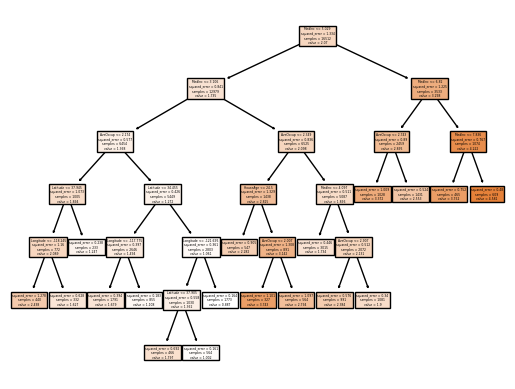

In [17]:
plot_tree(model_tree, filled=True, feature_names=X_train.columns)
plt.show()